In [2]:
import pandas as pd
import numpy as np
import time
import seaborn as sns
from matplotlib.colors import ListedColormap
import matplotlib.pyplot as plt
import requests
from bs4 import BeautifulSoup
import itertools
from copy import deepcopy as dcopy,copy
from scipy.ndimage import measurements
from skimage.morphology import label

from z3 import *
from IPython.display import Markdown, display

In [10]:
url='https://www.janestreet.com/puzzles/current-puzzle/'
res = requests.get(url)
soup = BeautifulSoup(res.content, 'html.parser')
y =[text for text in soup.body.stripped_strings]
#display([(i,j) for i,j in enumerate(y)])
display(Markdown("### "+y[8]+"\n\n"+str("\n".join(y[9:10]))))

### It's Symmetric 2

Shade some of the cells in the grid above so that the region of shaded
cells is connected and symmetric in some way (either by rotation or
reflection). Some of the cells have been numbered. These cells are in
the shaded region, and the numbers denote the products of the number
of shaded cells one can “see” within the region, in each of the 4
cardinal directions, before encountering an unshaded cell. (As in the
example, above.)

<img src="https://www.janestreet.com/puzzles/2021-07-01-its-symmetric-2.png
          " width="400">

In [232]:
# Set up the grids to be solved

grid1 =  np.array([[0, 0, 8, 0, 0],
                  [0, 0, 0, 0, 2],
                  [0, 0, 4, 0, 0],
                  [3, 0, 0, 0, 0],
                  [0, 0, 2, 0, 0]],dtype=int)

soln1 =  np.array([[1, 1, 1, 1, 1],
                  [1, 0, 1, 1, 1],              
                  [1, 1, 1, 0, 1],
                  [1, 1, 0, 0, 0],
                  [1, 1, 1, 0, 0]],dtype=int)

(0.0, 13.0, 13.0, 0.0)

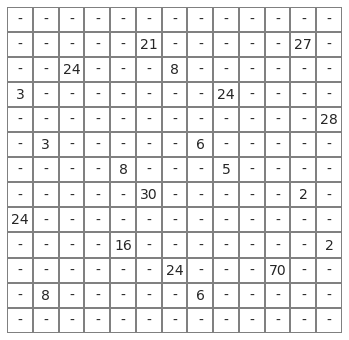

In [233]:
grid = np.array([[ 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
                 [ 0, 0, 0, 0, 0,21, 0, 0, 0, 0, 0,27, 0],
                 [ 0, 0,24, 0, 0, 0, 8, 0, 0, 0, 0, 0, 0],
                 [ 3, 0, 0, 0, 0, 0, 0, 0,24, 0, 0, 0, 0],
                 [ 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,28],
                 [ 0, 3, 0, 0, 0, 0, 0, 6, 0, 0, 0, 0, 0],
                 [ 0, 0, 0, 0, 8, 0, 0, 0, 5, 0, 0, 0, 0],
                 [ 0, 0, 0, 0, 0,30, 0, 0, 0, 0, 0, 2, 0],
                 [24, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
                 [ 0, 0, 0, 0,16, 0, 0, 0, 0, 0, 0, 0, 2],
                 [ 0, 0, 0, 0, 0, 0,24, 0, 0, 0,70, 0, 0],
                 [ 0, 8, 0, 0, 0, 0, 0, 6, 0, 0, 0, 0, 0],
                 [ 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]],
                dtype=int)

fig,ax = plt.subplots(1,1,figsize=(6,6))
x = np.zeros_like(grid)
y = grid.astype('str')
y[y=="0"] ="-"
sns.heatmap(x,annot=y,cmap='Greys',cbar=False,linecolor="grey",linewidths=1,fmt="",annot_kws={"size":14})
ax.axis('off')

In [376]:
def find(data,N):
    data += [0] * max(0, N - len(data))
    if N==13:
        return      If(data[1]==0,1,
                    If(data[2]==0,1,
                    If(data[3]==0,2,
                    If(data[4]==0,3,
                    If(data[5]==0,4,
                    If(data[6]==0,5,
                    If(data[7]==0,6,
                    If(data[8]==0,7,
                    If(data[9]==0,8,
                    If(data[10]==0,9,
                    If(data[11]==0,10,
                    If(data[12]==0,11,12)                
                   )))))))))))
    else:
        return     If(data[1]==0,1,
                   If(data[2]==0,1,
                   If(data[3]==0,2,
                   If(data[4]==0,3,4)
                   )))

def neighbours(i,j,N):
    l=[]
    if i-1 >= 0:
        l.append((i-1,j))
    if i+1 < N:
        l.append((i+1,j))
    if j-1 >= 0:
        l.append((i,j-1))
    if j+1 < N:
        l.append((i,j+1))
    return l


def solve(grid,fixed=np.ones_like(grid,dtype=int)*-1,sym_type=1):
    start = time.time()
    N = grid.shape[0]
    s = Solver()

    X = np.array([[Int("X_%s%s" % (i+1,j+1)) for j in range(N) ] for i in range(N) ],dtype=object)

    # limit the values and place the fixed values
    s += [Or(X[i][j]==0,X[i][j] ==1) for j in range(N) for i in range(N) ]
    s += [X[i][j] == int(fixed[i,j]) for j in range(N) for i in range(N) if fixed[i,j] != -1]
    
    # the numbered cells =1
    s+= [X[i][j] == 1 for j in range(N) for i in range(N) if grid[i,j] != 0]
    
    
    # force symmetry
    if sym_type == 0:
        pass
    
    elif sym_type == 1:
        test = np.rot90(np.fliplr(X))
        s += [X[i,j] == test[i,j] for j in range(N) for i in range(N)]
                
    elif sym_type == 2:
        test = np.rot90(X)
        s += [X[i][j] == test[i][j] for j in range(N) for i in range(N)]          
            
    elif sym_type == 3:
        z = 2
        cut = X[:-z,:-z]
        test = np.rot90((cut))
        s += [cut[i,j] == test[i,j] for j in range(N-z) for i in range(N-z)]
        
    elif sym_type ==4:
        test = np.fliplr(np.rot90(X))
        s += [X[i,j] == test[i,j] for j in range(N) for i in range(N)]
        
    elif sym_type == 5:
        z = 1
        cut = X[z:,:]
        test = np.flipud((cut))
        s += [cut[i,j] == test[i,j] for j in range(N) for i in range(N-z)]
    
    
    # find the looks
    for i,j in itertools.product(range(N),range(N)):
        val = grid[i,j]
        if val != 0:
            top = find([X[x][j] for x in range(i,-1,-1)],N)
            bot = find([X[x][j] for x in range(i,N)],N)
            lhs = find([X[i][x] for x in range(j,-1,-1)],N)
            rhs = find([X[i][x] for x in range(j,N)],N)
            #print(top*bot*lhs*rhs)
            s += top*bot*lhs*rhs == int(val)
                        
    # at least one neighbour. Cut down the connectivity a bit.
    s += [Implies(X[i][j] !=0,Or([X[k][l] !=0 for (k,l) in neighbours(i,j,N)])) for j in range(N) for i in range(N) ] 
        
    # coding up the connectivity is hard so just solve and test then exclude solutions that are not connected
    count = 0
    while True:   
        if s.check() == sat:
            count += 1
            m = s.model()
            x = np.array([[m.evaluate(X[i][j]).as_long() for j in range(N)] for i in range(N)])
            if np.max(label(x != 0,connectivity=1)) == 1 :
                print('{} solutions took {:0.4f} seconds'.format(count,time.time()-start))
                yield x,grid
            s += Or([X[i][j]!=int(x[i,j]) for j in range(N) for i in range(N)])
        else:
            print('Done in {:0.4f} seconds'.format(count,time.time()-start)) 
            break
            
            
def answer(grid):
    labels, num = measurements.label(np.logical_not(grid!=0))
    areas = measurements.sum(np.logical_not(grid!=0), labels, index=range(1, num+1))

    return np.sum([i**2 for i in areas])

1 solutions took 0.2972 seconds


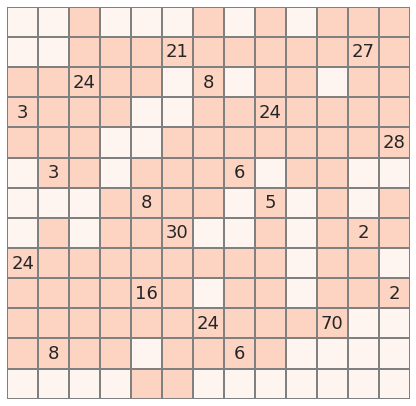

**The solution is 324**

In [378]:
for out,fix in solve(grid,sym_type =0 ):

    fig,ax = plt.subplots(1,1,figsize=(out.shape[0]**.5*2,out.shape[1]**.5*2)) 
    y = np.array(fix).astype('int').astype('str')
    y[y=="0"] =""
    sns.heatmap(out,annot=y,cbar=False,cmap="Reds",fmt="",linewidths=1,center=3,linecolor="grey",annot_kws={"size":18})
    ax.axis("off")
    plt.show()
    display(Markdown("**The solution is {:,.0f}**".format(answer(out))))
    break

In [256]:
# Pull in the puzzle solution and grids from the solution page
url='https://www.janestreet.com/puzzles/solutions/december-2020-solution/'
res = requests.get(url)
soup = BeautifulSoup(res.content, 'html.parser')
x =[text for text in soup.body.stripped_strings]
display(Markdown(("### "+x[6]+"\n"+" ".join(x[7:9]))))

### Contact us
What We Do Our Philosophy

<img src="" width="400">

1 solutions took 0.0419 seconds


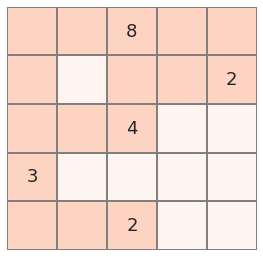

**The solution is 65**

In [370]:
for out,fix in solve(grid1,sym_type=3):
    fig,ax = plt.subplots(1,1,figsize=(out.shape[0]**.5*2,out.shape[1]**.5*2)) 
    y = np.array(fix).astype('int').astype('str')
    y[y=="0"] =""
    sns.heatmap(out,annot=y,cbar=False,cmap="Reds",fmt="",linewidths=1,center=3,linecolor="grey",annot_kws={"size":18})
    ax.axis("off")
    plt.show()
    display(Markdown("**The solution is {:,.0f}**".format(answer(out))))
    break

In [346]:
x = np.array([*range(5*5)]).reshape(5,5)
cut = x[1:,:]
print(cut)
np.flipud((cut))

[[ 5  6  7  8  9]
 [10 11 12 13 14]
 [15 16 17 18 19]
 [20 21 22 23 24]]


array([[20, 21, 22, 23, 24],
       [15, 16, 17, 18, 19],
       [10, 11, 12, 13, 14],
       [ 5,  6,  7,  8,  9]])

In [315]:
x = np.array([*range(25)]).reshape(5,5)
cut = x[1:,1:]
print(cut)
np.fliplr(np.rot90((cut),1))

[[ 6  7  8  9]
 [11 12 13 14]
 [16 17 18 19]
 [21 22 23 24]]


array([[24, 19, 14,  9],
       [23, 18, 13,  8],
       [22, 17, 12,  7],
       [21, 16, 11,  6]])

2 solutions took 1.5150 seconds


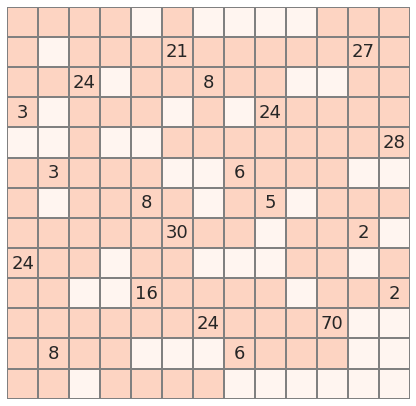

**The solution is 191**

In [319]:
for out,fix in solve(grid,sym_type =0 ):

    fig,ax = plt.subplots(1,1,figsize=(out.shape[0]**.5*2,out.shape[1]**.5*2)) 
    y = np.array(fix).astype('int').astype('str')
    y[y=="0"] =""
    sns.heatmap(out,annot=y,cbar=False,cmap="Reds",fmt="",linewidths=1,center=3,linecolor="grey",annot_kws={"size":18})
    ax.axis("off")
    plt.show()
    display(Markdown("**The solution is {:,.0f}**".format(answer(out))))
    break